<a href="https://colab.research.google.com/github/Sangameshchandan/Online-Retail-Customer-Segmentation/blob/main/Sangamesh_Online_Retail_Customer_Segmentation_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#1. LOADING THE DATASET

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_excel('/content/drive/MyDrive/ALMABETTER/Capstone Projects/4. Online Retail Customer Segmentation/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#2. DATA EXPLORATION

In [4]:
print("Retail transactions in the data set : {}".format(df.shape[0]))

Retail transactions in the data set : 541909


In [5]:
# Summary of data set.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
print("Duplicate transactions : {}".format(df.duplicated().sum()))

Duplicate transactions : 5268


In [7]:
# First five duplicate transactions
df[df.duplicated()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom


In [8]:
# Select transactions with InvoiceNo = '536409' & StockCode = '21866'
df.loc[(df['InvoiceNo'].astype(str) == '536409') & (df['StockCode'].astype(str) == '21866')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom


In [9]:
# Remove duplicates
df = df.drop(index=df[df.duplicated()].index)
print("Retail transactions after duplicates removal : {}".format(df.shape[0]))

Retail transactions after duplicates removal : 536641


In [10]:
# missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [11]:
# Descriptive statistics for StockCode.
df['StockCode'].describe()

count     536641
unique      4070
top       85123A
freq        2301
Name: StockCode, dtype: object

There are 4070 unique prodict codes. '85123A' is the most common product code appeared 2301 times.

In [12]:
# Descriptive statistics for Quantity.
df['Quantity'].describe()

count    536641.000000
mean          9.620029
std         219.130156
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [13]:
# Inspect min and max Quantity transactions
df.loc[(df['Quantity']==-80995) | (df['Quantity']==80995)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


Invoice No. 581483 of 80995 quantity sell of stock code 23843 is reversed by adding a contra entry. Invoice No. of such reversal/cancelled entries starts with letter 'C'.

In [14]:
# Cancelled/Reversed invoices
print("Cancelled invoices/transactions : {}".format(df[df['InvoiceNo'].astype(str).str[0] == 'C'].shape[0]))

Cancelled invoices/transactions : 9251


In [15]:
# Descriptive statistics for UnitPrice
df['UnitPrice'].describe()

count    536641.000000
mean          4.632656
std          97.233118
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

In [16]:
# Display transactions with negative unit price.
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Above transactions are looking to be a manual ledger adjustments. Also they don't have customer id.

In [17]:
# Dsiplay transaction with unit price > 10000
df[df['UnitPrice'] > 10000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,NaN,United Kingdom
16356,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,NaN,United Kingdom
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,16888.02,NaN,United Kingdom
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,16453.71,NaN,United Kingdom
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
524601,C580604,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:35:00,11586.50,NaN,United Kingdom
524602,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.46,NaN,United Kingdom


Most of the higher unit price transactions are related to Amazon fee for selling the product through their platform. Such transactions don't have customer id.

In [18]:
print("Transactions with zero unit price : {}".format(df[df['UnitPrice'] == 0].shape[0]))

Transactions with zero unit price : 2510


In [19]:
#First five transactions with zero unit price
df[df['UnitPrice'] == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


In [20]:
# top 10 selling products by their counts in data set.
df['Description'].value_counts().sort_values(ascending=False)[:10]

WHITE HANGING HEART T-LIGHT HOLDER    2357
REGENCY CAKESTAND 3 TIER              2189
JUMBO BAG RED RETROSPOT               2156
PARTY BUNTING                         1720
LUNCH BAG RED RETROSPOT               1625
ASSORTED COLOUR BIRD ORNAMENT         1488
SET OF 3 CAKE TINS PANTRY DESIGN      1465
PACK OF 72 RETROSPOT CAKE CASES       1367
LUNCH BAG  BLACK SKULL.               1323
NATURAL SLATE HEART CHALKBOARD        1272
Name: Description, dtype: int64

In [21]:
# Descriptive Statistics for Country
df['Country'].describe()

count             536641
unique                38
top       United Kingdom
freq              490300
Name: Country, dtype: object

Majority of customers resides in United Kingdom

In [22]:
#Remove transactions with missing customer ids
df = df.drop(index=df[df['CustomerID'].isnull()].index)
print("Retail transactions after removing missing customer ids  : {}".format(df.shape[0]))

Retail transactions after removing missing customer ids  : 401604


In [23]:
import datetime as dt

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


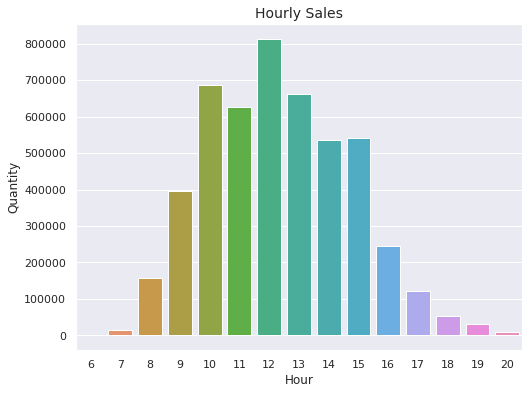

In [24]:
hourly_sales = df[['Hour', 'Quantity']].groupby('Hour').sum()
plt.figure(figsize=(8,6))
plt.title("Hourly Sales", fontsize=14)
sns.barplot(hourly_sales.index, hourly_sales['Quantity'])

The majority of the sales happens in between 10am to 3pm.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


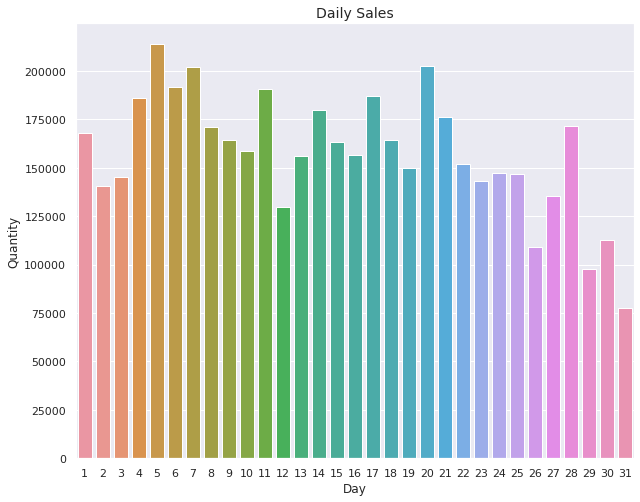

In [25]:
daily_sales = df[['Day', 'Quantity']].groupby('Day').sum()
plt.figure(figsize=(10,8))
plt.title("Daily Sales", fontsize=14)
sns.barplot(daily_sales.index, daily_sales['Quantity'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


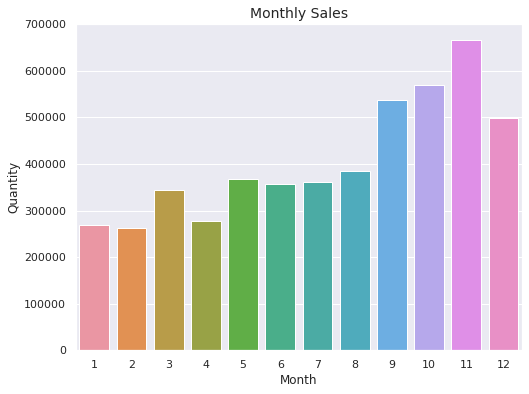

In [26]:
monthly_sales = df[['Month', 'Quantity']].groupby('Month').sum()
plt.figure(figsize=(8,6))
plt.title("Monthly Sales", fontsize=14)
sns.barplot(monthly_sales.index, monthly_sales['Quantity'])

Most of the sales happened in between September and December month.

#3. Customer RFM (Recency, Frequency, Monetary) analysis




What is RFM technique ?

RFM (Recency, Frequency, Monetary) analysis is a proven marketing model for behavior based customer segmentation. It groups customers based on their transaction history – how recently, how often and how much did they buy.

RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

Recency : How much time has elapsed since a customer's last activity or transaction with the brand?

Frequency : How often has a customer transacted or interacted with the brand during a particular period of time?

Monetary : How much a customer has spent with the brand during a particular period of time?

In [27]:
# Recency -> The freshness of customer purchase

# Calculate latest date from data set.
max_date = df['InvoiceDate'].max()
# Calculate days passed since customer's last purchase.
df['Days_passed'] = max_date -  df['InvoiceDate']
df['Days_passed'] = df['Days_passed'].dt.days
# Group Recency by customer id
recency = df[['CustomerID', 'Days_passed']].groupby('CustomerID').min()
recency.head(5)

,Days_passed
CustomerID,
12346.0,325
12347.0,1
12348.0,74
12349.0,18
12350.0,309


In [28]:
# Frequency of the customer transactions
frequency = df[['CustomerID','InvoiceNo']].groupby('CustomerID').count()
frequency.head()

,InvoiceNo
CustomerID,
12346.0,2
12347.0,182
12348.0,31
12349.0,73
12350.0,17


In [29]:
# Monetory -> purchasing power of the customer
df['SaleAmount'] = df['Quantity'] * df['UnitPrice']
monetory = df[['CustomerID', 'SaleAmount']].groupby('CustomerID').sum()
monetory.head()

,SaleAmount
CustomerID,
12346.0,0.00
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


In [30]:
# Merge recency, frequency and monetory dataframes
RFM = recency.merge(frequency,on='CustomerID').merge(monetory, on='CustomerID')
RFM = RFM.rename(columns={"Days_passed": "Recency", "InvoiceNo": "Frequency", "SaleAmount" : "Monetory"})
RFM.head()

,Recency,Frequency,Monetory
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40


#4. KMeans clustering

In [31]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=5)
    cluster_labels = clusterer.fit_predict(RFM)
    
    silhouette_avg = silhouette_score(RFM, cluster_labels)
    print("for n_clusters =", n_clusters, "Average Silhouette score = ", silhouette_avg)

for n_clusters = 2 Average Silhouette score =  0.98630357275616
for n_clusters = 3 Average Silhouette score =  0.9630745414576583
for n_clusters = 4 Average Silhouette score =  0.8770783791563798
for n_clusters = 5 Average Silhouette score =  0.8148946297109425
for n_clusters = 6 Average Silhouette score =  0.7754320568833175
for n_clusters = 7 Average Silhouette score =  0.7754383143667688
for n_clusters = 8 Average Silhouette score =  0.7213953316267048


In [32]:
# Kmeans with number of clusers = 4
clusterer = KMeans(n_clusters=4, random_state=5)
cluster_labels = clusterer.fit_predict(RFM)

In [33]:
RFM['Cluster'] = cluster_labels
RFM.groupby('Cluster').mean()

,Recency,Frequency,Monetory
Cluster,,,
0,93.502007,75.426919,1128.677111
1,2.666667,956.000000,241083.226667
2,6.866667,1508.466667,71538.928000
3,16.521008,476.268908,14304.523193


Cluster 0 contains group of customers with low value of Recency, Frequency and Monetory

Cluster 1 contains group of customers with high Monetory value

Cluster 2 contains group of customers with high Frequnecy value

Cluster 3 contains group of customers with moderate value of Recency, Frequnecy and Monetory

#5. Principal component analysis (PCA)

In [34]:
from sklearn.pipeline import make_pipeline

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(),
                    PCA(n_components=2, random_state=43))
RFM_transformed = pca.fit_transform(RFM)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Clusters')

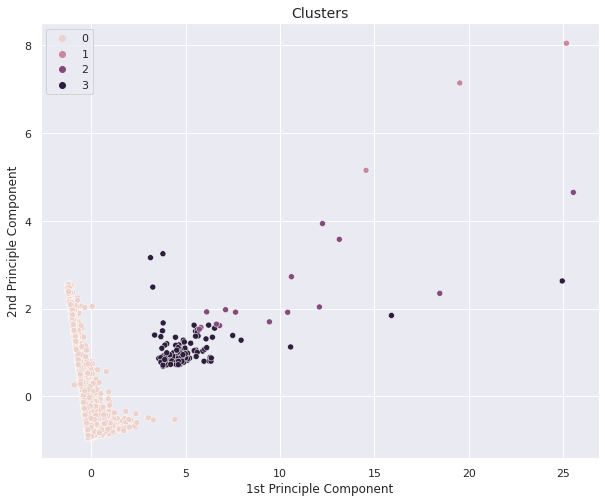

In [35]:
plt.figure(figsize=(10,8))
sns.scatterplot(RFM_transformed[:,0], RFM_transformed[:,1], hue=cluster_labels)
plt.xlabel('1st Principle Component')
plt.ylabel('2nd Principle Component')
plt.title("Clusters", fontsize=14)